In [36]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 

import tensorflow as tf 
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, Embedding, Activation, BatchNormalization, Dropout, Dot, Add, Flatten, Dense

from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping

from wordcloud import WordCloud

%matplotlib inline




In [2]:
!pip install matplotlib wordcloud


  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached kiwisolver-1.4.8-cp312-cp312-win_amd64.whl.metadata (6.3 kB)
  Using cached pyparsing-3.2.3-py3-none-any.whl.metadata (5.0 kB)
   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   - -------------------------------------- 0.3/8.1 MB ? eta -:--:--
   - -------------------------------------- 0.3/8.1 MB ? eta -:--:--
   - -------------------------------------- 0.3/8.1 MB ? eta -:--:--
   -- ------------------------------------- 0.5/8.1 MB 381.0 kB/s eta 0:00:20
   ------ --------------------------------- 1.3/8.1 MB 1.0 MB/s eta 0:00:07
   --------- ------------------------------ 1.8/8.1 MB 1.4 MB/s eta 0:00:05
   ---------- ----------------------------- 2.1/8.1 MB 1.3 MB/s eta 0:00:05
   -------------- ------------------------- 2.9/8.1 MB 1.6 MB/s eta 0:00:04
   --------------- ------------------------ 3.1/8.1 MB 1.6 MB/s eta 0:00:04
   ------------------ --------------------- 3.7/8.1 MB 1.6 M


[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


### READING ANIME LIST.csv

In [2]:
import os

In [3]:
INPUT_DIR = os.path.join("..", "artifacts","raw")



In [4]:
rating_df = pd.read_csv(INPUT_DIR + "/animelist.csv", low_memory=True, usecols=["user_id", "anime_id", "rating"])


In [5]:
rating_df.head()


,user_id,anime_id,rating
0,0,67,9
1,0,6702,7
2,0,242,10
3,0,4898,0
4,0,21,10


In [6]:
len(rating_df)




5000000

###Data Preprocessing


In [7]:
n_ratings = rating_df["user_id"].value_counts()
rating_df = rating_df[rating_df["user_id"].isin(n_ratings[n_ratings >= 400].index)].copy()






In [8]:
len(rating_df)

3246641

In [9]:
min_rating = min(rating_df["rating"])
max_rating = max(rating_df["rating"])







In [10]:
avg_rating = rating_df["rating"].mean()


In [11]:
max_rating


10

In [12]:
# min max scaler

rating_df["rating"] = rating_df["rating"].apply(lambda X: (X - min_rating) / (max_rating - min_rating)).values.astype(np.float64)


In [13]:
rating_df.isnull().sum()



user_id     0
anime_id    0
rating      0
dtype: int64

In [14]:
user_ids = rating_df['user_id'].unique().tolist()
user2user_encoded = {x: i for i , x in enumerate(user_ids)}
user2user_decoded = {i: x for i , x in enumerate(user_ids)}
rating_df["user"] = rating_df["user_id"].map(user2user_encoded)


In [17]:
n_users = len(user2user_encoded)


In [18]:
n_users

4203

In [ ]:
#### USER ---> 10054 ----> 98


In [19]:
anime_ids = rating_df['anime_id'].unique().tolist()
anime2anime_encoded = {x: i for i , x in enumerate(anime_ids)}
anime2anime_decoded = {i: x for i , x in enumerate(anime_ids)}
rating_df["anime"] = rating_df["anime_id"].map(anime2anime_encoded)

In [20]:
n_anime = len(anime2anime_encoded)


In [21]:
n_anime


17149

In [22]:
rating_df = rating_df.sample(frac=1,random_state=42).reset_index(drop=True)


In [23]:
X = rating_df[["user", "anime"]].values
y = rating_df["rating"].values



In [24]:
test_size = 1000
train_indices = rating_df.shape[0] - test_size

X_train, X_test, y_train, y_test = X[:train_indices], X[train_indices:], y[:train_indices], y[train_indices:]






In [31]:
X_train


array([[3405,  688],
       [4060, 1518],
       [1213, 4963],
       ...,
       [ 560, 1461],
       [3815, 1512],
       [2122, 1153]])

In [26]:
len(X_test)


1000

In [27]:
type(X_train)


numpy.ndarray

In [28]:
X_train_array = [X_train[: , 0], X_train[: , 1]]
X_test_array = [X_test[: , 0], X_test[: , 1]]   


In [29]:
type(X_train_array)


list

In [32]:
type(X_test_array[0])


numpy.ndarray

#### MOODEL ARCHITECTURE

In [37]:
def RecommenderNet():
    embedding_size = 128

    user = Input(name="user", shape=[1])

    user_embedding = Embedding(name="user_embedding", input_dim=n_users, output_dim=embedding_size)(user)

    anime = Input(name="anime", shape=[1])

    anime_embedding = Embedding(name="anime_embedding", input_dim=n_anime, output_dim=embedding_size)(anime)

    x = Dot(name="dot_product",normalize=True, axes=2)([user_embedding, anime_embedding])

    x = Flatten()(x)

    x = Dense(1, kernel_initializer="he_normal")(x)
    x = BatchNormalization()(x)
    x = Activation("sigmoid")(x)

    model = Model([user, anime], x)
    model.compile(loss="binary_crossentropy",metrics=["mae", "mse"], optimizer=Adam(learning_rate=0.001))

    return model


In [38]:
model  = RecommenderNet()

model.summary()






Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ user (InputLayer)   │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ anime (InputLayer)  │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_embedding      │ (None, 1, 128)    │    537,984 │ user[0][0]        │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ anime_embedding     │ (None, 1, 128)    │  2,195,072 │ anime[0][0]       │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot_product (Dot)   │ (None, 1, 1)      │          0 │ user_embedding[0… │
│                     │                   │            │ anime_embedding[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 1)         │          0 │ dot_product[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1)         │          2 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 1)         │          4 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 1)         │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,733,062 (10.43 MB)

 Trainable params: 2,733,060 (10.43 MB)

 Non-trainable params: 2 (8.00 B)

In [39]:
start_lr = 0.00001
min_lr = 0.0001
max_lr = 0.00005
batch_size = 10000

ramup_epochs = 5
sustain_epochs = 0
exp_decay = 0.8

def lrfn(epoch):
    if epoch < ramup_epochs:
        return (max_lr-start_lr)/ramup_epochs * epoch + start_lr
    elif epoch < ramup_epochs + sustain_epochs:
        return max_lr
    else:
        return (max_lr-min_lr)*exp_decay**(epoch-ramup_epochs-sustain_epochs) + min_lr






In [40]:
lr_callback = LearningRateScheduler(lambda epoch:lrfn(epoch) , verbose=0)
checkpoint_filepath = './weights.weights.h5'

model_checkpoint= ModelCheckpoint(filepath=checkpoint_filepath,save_weights_only=True,monitor="val_loss",mode="min",save_best_only=True)

early_stopping = EarlyStopping(monitor="val_loss",patience=3,mode="min",restore_best_weights=True)








In [41]:
my_callbacks = [model_checkpoint, lr_callback, early_stopping]


In [42]:
history = model.fit(X_train_array, y_train, batch_size=batch_size, epochs=20,verbose=1, validation_data=(X_test_array, y_test), callbacks=my_callbacks)


Epoch 1/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 27s 51ms/step - loss: 0.7118 - mae: 0.3650 - mse: 0.1644 - val_loss: 0.6924 - val_mae: 0.3627 - val_mse: 0.1566 - learning_rate: 1.0000e-05
Epoch 2/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 16s 48ms/step - loss: 0.7098 - mae: 0.3643 - mse: 0.1634 - val_loss: 0.6963 - val_mae: 0.3623 - val_mse: 0.1584 - learning_rate: 1.8000e-05
Epoch 3/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 16s 49ms/step - loss: 0.7061 - mae: 0.3632 - mse: 0.1618 - val_loss: 0.7010 - val_mae: 0.3631 - val_mse: 0.1606 - learning_rate: 2.6000e-05
Epoch 4/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 21s 49ms/step - loss: 0.7017 - mae: 0.3616 - mse: 0.1596 - val_loss: 0.6978 - val_mae: 0.3627 - val_mse: 0.1590 - learning_rate: 3.4000e-05


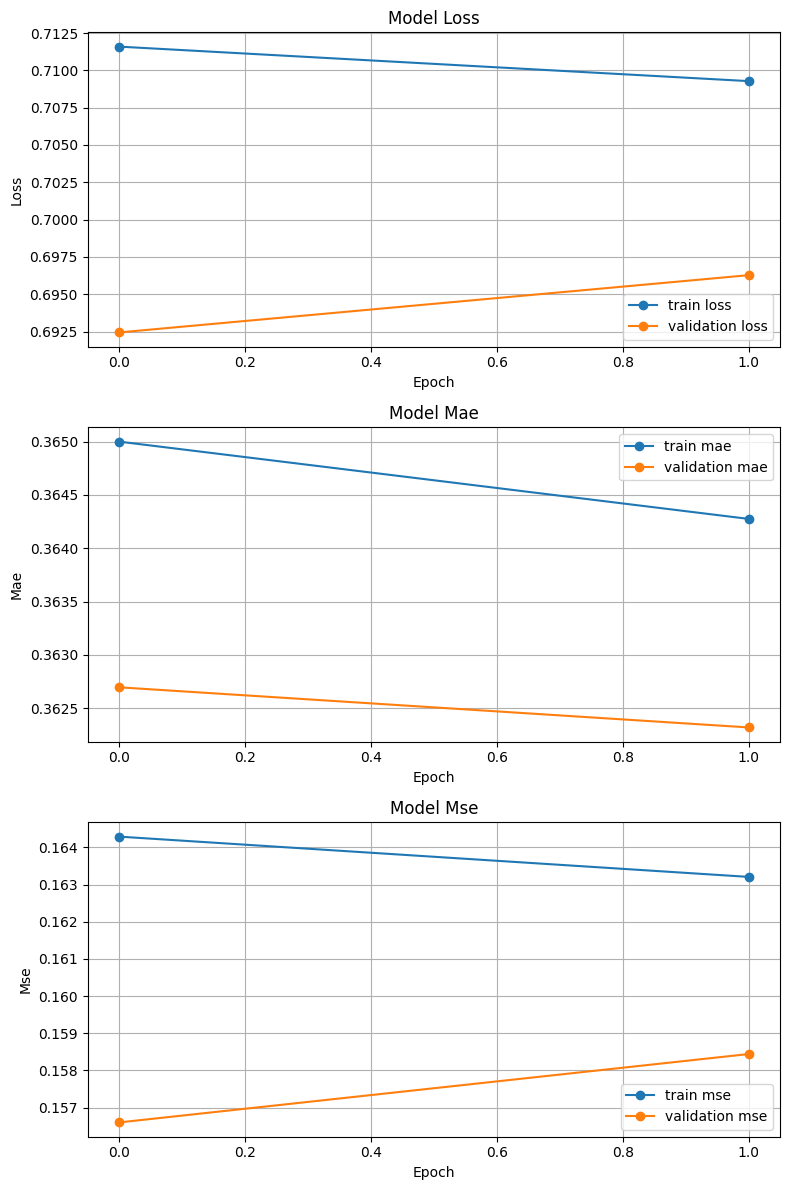

In [44]:
metrics = ["loss", "mae", "mse"]

fig,axes = plt.subplots(len(metrics),1,figsize=(8,4*len(metrics)))

for i, metric in enumerate(metrics):
    ax = axes[i]
    ax.plot(history.history[metric][0:-2], marker="o", label=f"train {metric}")
    ax.plot(history.history[f"val_{metric}"][0:-2], marker="o", label=f"validation {metric}")
    ax.set_title(f"Model {metric.capitalize()}")
    ax.set_ylabel(metric.capitalize())
    ax.set_xlabel("Epoch")
    ax.legend(loc="best")
    ax.grid(True)
plt.tight_layout()
plt.show()




In [45]:
def extract_weights(name,model):
    weight_layer = model.get_layer(name)
    weights = weight_layer.get_weights()[0]
    weights = weights/np.linalg.norm(weights,axis=1).reshape((-1,1))
    
    return weights







In [46]:
anime_weights = extract_weights("anime_embedding", model)
user_weights = extract_weights("user_embedding", model)







#### READING ANIME>CSV``

In [47]:
df = pd.read_csv(INPUT_DIR+"/anime.csv", low_memory=True,)


In [48]:
df.head()


,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,...,Score-10,Score-9,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,カウボーイビバップ,TV,26,"Apr 3, 1998 to Apr 24, 1999",Spring 1998,...,229170.0,182126.0,131625.0,62330.0,20688.0,8904.0,3184.0,1357.0,741.0,1580.0
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Cowboy Bebop:The Movie,カウボーイビバップ 天国の扉,Movie,1,"Sep 1, 2001",Unknown,...,30043.0,49201.0,49505.0,22632.0,5805.0,1877.0,577.0,221.0,109.0,379.0
2,6,Trigun,8.24,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen",Trigun,トライガン,TV,26,"Apr 1, 1998 to Sep 30, 1998",Spring 1998,...,50229.0,75651.0,86142.0,49432.0,15376.0,5838.0,1965.0,664.0,316.0,533.0
3,7,Witch Hunter Robin,7.27,"Action, Mystery, Police, Supernatural, Drama, ...",Witch Hunter Robin,Witch Hunter ROBIN (ウイッチハンターロビン),TV,26,"Jul 2, 2002 to Dec 24, 2002",Summer 2002,...,2182.0,4806.0,10128.0,11618.0,5709.0,2920.0,1083.0,353.0,164.0,131.0
4,8,Bouken Ou Beet,6.98,"Adventure, Fantasy, Shounen, Supernatural",Beet the Vandel Buster,冒険王ビィト,TV,52,"Sep 30, 2004 to Sep 29, 2005",Fall 2004,...,312.0,529.0,1242.0,1713.0,1068.0,634.0,265.0,83.0,50.0,27.0


In [49]:
df = df.replace("Unknown", np.nan)


In [52]:
def getAmineName(anime_id):
    try:
        name = df[df.anime_id == anime_id].eng_version.values[0]
        if name is np.nan:
            name = df[df.anime_id == anime_id].Name.values[0]
    except:
        print("Error")
    return name


In [54]:
df["anime_id"] = df["MAL_ID"]
df["eng_version"] = df["English name"]
df["eng_version"] = df.anime_id.apply(lambda x:getAmineName(x))


In [55]:
df.head()



,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,...,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1,anime_id,eng_version
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,カウボーイビバップ,TV,26,"Apr 3, 1998 to Apr 24, 1999",Spring 1998,...,131625.0,62330.0,20688.0,8904.0,3184.0,1357.0,741.0,1580.0,1,Cowboy Bebop
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Cowboy Bebop:The Movie,カウボーイビバップ 天国の扉,Movie,1,"Sep 1, 2001",NaN,...,49505.0,22632.0,5805.0,1877.0,577.0,221.0,109.0,379.0,5,Cowboy Bebop:The Movie
2,6,Trigun,8.24,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen",Trigun,トライガン,TV,26,"Apr 1, 1998 to Sep 30, 1998",Spring 1998,...,86142.0,49432.0,15376.0,5838.0,1965.0,664.0,316.0,533.0,6,Trigun
3,7,Witch Hunter Robin,7.27,"Action, Mystery, Police, Supernatural, Drama, ...",Witch Hunter Robin,Witch Hunter ROBIN (ウイッチハンターロビン),TV,26,"Jul 2, 2002 to Dec 24, 2002",Summer 2002,...,10128.0,11618.0,5709.0,2920.0,1083.0,353.0,164.0,131.0,7,Witch Hunter Robin
4,8,Bouken Ou Beet,6.98,"Adventure, Fantasy, Shounen, Supernatural",Beet the Vandel Buster,冒険王ビィト,TV,52,"Sep 30, 2004 to Sep 29, 2005",Fall 2004,...,1242.0,1713.0,1068.0,634.0,265.0,83.0,50.0,27.0,8,Beet the Vandel Buster


In [57]:
getAmineName(67)


'Basilisk'

In [60]:
df.sort_values(by=["Score"],
               inplace=True,
               ascending=False,
               kind="quicksort",
               na_position="last",
               )


In [61]:
df.head()


,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,...,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1,anime_id,eng_version
3971,5114,Fullmetal Alchemist: Brotherhood,9.19,"Action, Military, Adventure, Comedy, Drama, Ma...",Fullmetal Alchemist:Brotherhood,鋼の錬金術師 FULLMETAL ALCHEMIST,TV,64,"Apr 5, 2009 to Jul 4, 2010",Spring 2009,...,199160.0,70045.0,20210.0,9308.0,3222.0,1536.0,2162.0,16806.0,5114,Fullmetal Alchemist:Brotherhood
15926,40028,Shingeki no Kyojin: The Final Season,9.17,"Action, Military, Mystery, Super Power, Drama,...",Attack on Titan Final Season,進撃の巨人 The Final Season,TV,16,"Dec 7, 2020 to ?",Winter 2021,...,26016.0,8793.0,2674.0,1336.0,588.0,382.0,514.0,11061.0,40028,Attack on Titan Final Season
5683,9253,Steins;Gate,9.11,"Thriller, Sci-Fi",Steins;Gate,STEINS;GATE,TV,24,"Apr 6, 2011 to Sep 14, 2011",Spring 2011,...,140914.0,57740.0,21375.0,11126.0,5061.0,2292.0,1678.0,5255.0,9253,Steins;Gate
14963,38524,Shingeki no Kyojin Season 3 Part 2,9.1,"Action, Drama, Fantasy, Military, Mystery, Sho...",Attack on Titan Season 3 Part 2,進撃の巨人 Season3 Part.2,TV,10,"Apr 29, 2019 to Jul 1, 2019",Spring 2019,...,110481.0,33662.0,8365.0,2974.0,1108.0,550.0,385.0,4169.0,38524,Attack on Titan Season 3 Part 2
9913,28977,Gintama°,9.1,"Action, Comedy, Historical, Parody, Samurai, S...",Gintama Season 4,銀魂°,TV,51,"Apr 8, 2015 to Mar 30, 2016",Spring 2015,...,21360.0,10215.0,3898.0,2311.0,952.0,648.0,1100.0,4508.0,28977,Gintama Season 4


In [62]:
df.columns

Index(['MAL_ID', 'Name', 'Score', 'Genres', 'English name', 'Japanese name',
       'Type', 'Episodes', 'Aired', 'Premiered', 'Producers', 'Licensors',
       'Studios', 'Source', 'Duration', 'Rating', 'Ranked', 'Popularity',
       'Members', 'Favorites', 'Watching', 'Completed', 'On-Hold', 'Dropped',
       'Plan to Watch', 'Score-10', 'Score-9', 'Score-8', 'Score-7', 'Score-6',
       'Score-5', 'Score-4', 'Score-3', 'Score-2', 'Score-1', 'anime_id',
       'eng_version'],
      dtype='object')

In [64]:
df = df[["anime_id", "eng_version","Score", "Genres", "Episodes", "Type","Premiered","Members"]]

In [65]:
df.head()


,anime_id,eng_version,Score,Genres,Episodes,Type,Premiered,Members
3971,5114,Fullmetal Alchemist:Brotherhood,9.19,"Action, Military, Adventure, Comedy, Drama, Ma...",64,TV,Spring 2009,2248456
15926,40028,Attack on Titan Final Season,9.17,"Action, Military, Mystery, Super Power, Drama,...",16,TV,Winter 2021,733260
5683,9253,Steins;Gate,9.11,"Thriller, Sci-Fi",24,TV,Spring 2011,1771162
14963,38524,Attack on Titan Season 3 Part 2,9.1,"Action, Drama, Fantasy, Military, Mystery, Sho...",10,TV,Spring 2019,1073626
9913,28977,Gintama Season 4,9.1,"Action, Comedy, Historical, Parody, Samurai, S...",51,TV,Spring 2015,404121


In [66]:
def getAnimeFrame(anime,df):
    try:
        if isinstance(anime,int):
            return df[df["anime_id"] == anime]
        elif isinstance(anime,str):
            return df[df["eng_version"] == anime]
        else:
            raise ValueError("Invalid input")
    except:
        print("Error")
        return None







In [67]:
getAnimeFrame(40028, df)

,anime_id,eng_version,Score,Genres,Episodes,Type,Premiered,Members
15926,40028,Attack on Titan Final Season,9.17,"Action, Military, Mystery, Super Power, Drama,...",16,TV,Winter 2021,733260


In [68]:
getAnimeFrame("Fullmetal Alchemist", df)



,anime_id,eng_version,Score,Genres,Episodes,Type,Premiered,Members
100,121,Fullmetal Alchemist,8.17,"Action, Adventure, Comedy, Drama, Fantasy, Mag...",51,TV,Fall 2003,1151621


#### ANIME WITH SYNOPSIS>CSV

In [74]:
cols = ["MAL_ID", "Name", "Genres", "sypnopsis"]


In [75]:
synopsys_df = pd.read_csv(INPUT_DIR+"/anime_with_synopsis.csv", low_memory=True, usecols=cols)


In [76]:
synopsys_df.head()


,MAL_ID,Name,Genres,sypnopsis
0,1,Cowboy Bebop,"Action, Adventure, Comedy, Drama, Sci-Fi, Space","In the year 2071, humanity has colonized sever..."
1,5,Cowboy Bebop: Tengoku no Tobira,"Action, Drama, Mystery, Sci-Fi, Space","other day, another bounty—such is the life of ..."
2,6,Trigun,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen","Vash the Stampede is the man with a $$60,000,0..."
3,7,Witch Hunter Robin,"Action, Mystery, Police, Supernatural, Drama, ...",ches are individuals with special powers like ...
4,8,Bouken Ou Beet,"Adventure, Fantasy, Shounen, Supernatural",It is the dark century and the people are suff...


In [77]:
def getSynopsis(anime_id):
    try:
        if isinstance(anime_id,int):
            return synopsys_df[synopsys_df["MAL_ID"] == anime_id].sypnopsis.values[0]
        elif isinstance(anime_id,str):
            return synopsys_df[synopsys_df["Name"] == anime_id].sypnopsis.values[0]
        else:
            raise ValueError("Invalid input")
    except:
        print("Error")
        return None
        


In [79]:
getSynopsis("Fullmetal Alchemist")


"Edward Elric, a young, brilliant alchemist, has lost much in his twelve-year life: when he and his brother Alphonse try to resurrect their dead mother through the forbidden act of human transmutation, Edward loses his brother as well as two of his limbs. With his supreme alchemy skills, Edward binds Alphonse's soul to a large suit of armor. A year later, Edward, now promoted to the fullmetal alchemist of the state, embarks on a journey with his younger brother to obtain the Philosopher's Stone. The fabled mythical object is rumored to be capable of amplifying an alchemist's abilities by leaps and bounds, thus allowing them to override the fundamental law of alchemy: to gain something, an alchemist must sacrifice something of equal value. Edward hopes to draw into the military's resources to find the fabled stone and restore his and Alphonse's bodies to normal. However, the Elric brothers soon discover that there is more to the legendary stone than meets the eye, as they are led to the

In [81]:
synopsys_df.head()


,MAL_ID,Name,Genres,sypnopsis
0,1,Cowboy Bebop,"Action, Adventure, Comedy, Drama, Sci-Fi, Space","In the year 2071, humanity has colonized several of the planets and moons of the solar system leaving the now uninhabitable surface of planet Earth behind. The Inter Solar System Police attempts to keep peace in the galaxy, aided in part by outlaw bounty hunters, referred to as ""Cowboys."" The ragtag team aboard the spaceship Bebop are two such individuals. Mellow and carefree Spike Spiegel is balanced by his boisterous, pragmatic partner Jet Black as the pair makes a living chasing bounties and collecting rewards. Thrown off course by the addition of new members that they meet in their travels—Ein, a genetically engineered, highly intelligent Welsh Corgi; femme fatale Faye Valentine, an enigmatic trickster with memory loss; and the strange computer whiz kid Edward Wong—the crew embarks on thrilling adventures that unravel each member's dark and mysterious past little by little. Well-balanced with high density action and light-hearted comedy, Cowboy Bebop is a space Western classic and an homage to the smooth and improvised music it is named after."
1,5,Cowboy Bebop: Tengoku no Tobira,"Action, Drama, Mystery, Sci-Fi, Space","other day, another bounty—such is the life of the often unlucky crew of the Bebop. However, this routine is interrupted when Faye, who is chasing a fairly worthless target on Mars, witnesses an oil tanker suddenly explode, causing mass hysteria. As casualties mount due to a strange disease spreading through the smoke from the blast, a whopping three hundred million woolong price is placed on the head of the supposed perpetrator. With lives at stake and a solution to their money problems in sight, the Bebop crew springs into action. Spike, Jet, Faye, and Edward, followed closely by Ein, split up to pursue different leads across Alba City. Through their individual investigations, they discover a cover-up scheme involving a pharmaceutical company, revealing a plot that reaches much further than the ragtag team of bounty hunters could have realized."
2,6,Trigun,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen","Vash the Stampede is the man with a $$60,000,000,000 bounty on his head. The reason: he's a merciless villain who lays waste to all those that oppose him and flattens entire cities for fun, garnering him the title ""The Humanoid Typhoon."" He leaves a trail of death and destruction wherever he goes, and anyone can count themselves dead if they so much as make eye contact—or so the rumors say. In actuality, Vash is a huge softie who claims to have never taken a life and avoids violence at all costs. With his crazy doughnut obsession and buffoonish attitude in tow, Vash traverses the wasteland of the planet Gunsmoke, all the while followed by two insurance agents, Meryl Stryfe and Milly Thompson, who attempt to minimize his impact on the public. But soon, their misadventures evolve into life-or-death situations as a group of legendary assassins are summoned to bring about suffering to the trio. Vash's agonizing past will be unraveled and his morality and principles pushed to the breaking point."
3,7,Witch Hunter Robin,"Action, Mystery, Police, Supernatural, Drama, Magic","ches are individuals with special powers like ESP, telekinesis, mind control, etc. Robin, a 15-year-old craft user, arrives from Italy to Japan to work for an organization named STN Japan Division (STN-J) as a replacement for one of STN-J's witch hunters who was recently killed. Unlike other divisions of STN, STN-J tries to capture the witches alive in order to learn why and how they became witches in the first place. (Source: ANN)"
4,8,Bouken Ou Beet,"Adventure, Fantasy, Shounen, Supernatural","It is the dark century and the people are suffering under the rule of the devil, Vandel, who is able to manipulate monsters. The Vandel Busters are a group of people who hunt these devils, and among them, the Zenon Squad is known to be the stronge

#### CONTENT/ITEM BASED RECOMMENDATION


In [80]:
pd.set_option("max_colwidth", None)


In [96]:
def find_similar_animes(name, anime_weights, anime2anime_encoded,
                        anime2anime_decoded, df, synopsys_df,
                        n=10, return_dist=False,
                        neg=False):
    try:
        index = getAnimeFrame(name, df).anime_id.values[0]
        encoded_index = anime2anime_encoded.get(index)

        if encoded_index is None:
            raise ValueError(f"Anime ID {index} not found in encoding.")

        dists = np.dot(anime_weights, anime_weights[encoded_index])
        sorted_dists = np.argsort(dists)

        n = n + 1

        if neg:
            closest = sorted_dists[:n]
        else:
            closest = sorted_dists[-n:][::-1]

        print(f"Anime closest to {name}")

        if return_dist:
            return dists, closest

        similarityArr = []
        for close in closest:
            decoded_id = anime2anime_decoded.get(close)
            if decoded_id is None:
                continue

            synopsis = getSynopsis(decoded_id)
            anime_frame = getAnimeFrame(decoded_id, df)

            if anime_frame.empty:
                continue

            anime_name = anime_frame.eng_version.values[0]
            genre = anime_frame.Genres.values[0]
            similarity = dists[close]

            similarityArr.append({
                "anime_id": decoded_id,
                "name": anime_name,
                "similarity": similarity,
                "genre": genre,
                "synopsis": synopsis
            })

        Frame = pd.DataFrame(similarityArr).sort_values(by="similarity", ascending=False)

        return Frame[Frame.anime_id != index].drop("anime_id", axis=1)

    except Exception as e:
        print(f"Error Occurred: {e}")


In [99]:
find_similar_animes("Fullmetal Alchemist",anime_weights,anime2anime_encoded,anime2anime_decoded,df,synopsys_df,n=2)


Anime closest to Fullmetal Alchemist


,name,similarity,genre,synopsis
1,Star Blazers:The Comet Empire,0.352347,"Action, Military, Sci-Fi, Adventure, Space, Drama","ar has passed since the Star Force returned to save the Earth but another danger now approaches from deep space. A gigantic White Comet hurtles toward our galaxy, obliterating everything in its path. But it is no ordinary comet—it is the deadly Comet Empire, conqueror of worlds... and Earth is the next target! Against orders, the Star Force blasts off to investigate, but even if they can get past the flagship Andromeda, they don't yet know the true nature of their new enemy! (Source: AniDB)"
2,Agitation!,0.325345,Music,"Official music video for the song Agitation! . It is the 44th song in the franchise and focuses ""Maigahara Koukou Keion-bu,"" an after school club band with Nanase Hagiwara, Nadeshiko Igarashi, and Minae Ono as members."


#### USER BASED RECOMMENDATION- COLLABORATIVE FILTERING


In [107]:
def find_similar_users(item_input, user_weights, user2user_encoded, user2user_decoded, 
                       n=10, return_dist=False, neg=False):
    try:
        index = item_input
        encoded_index = user2user_encoded.get(index)

        if encoded_index is None:
            raise ValueError(f"User ID {index} not found in encoded dictionary.")

        weights = user_weights
        dists = np.dot(weights, weights[encoded_index])
        sorted_dists = np.argsort(dists)

        n = n + 1  # include self

        if neg:
            closest = sorted_dists[:n]
        else:
            closest = sorted_dists[-n:][::-1]

        if return_dist:
            return dists, closest

        similarityArr = []
        for close in closest:
            similarity = dists[close]
            decoded_id = user2user_decoded.get(close)

            if decoded_id is None:
                print(f"Warning: user2user_decoded missing index {close}")
                continue

            if decoded_id != index:
                similarityArr.append({
                    "similar_users": decoded_id,
                    "similarity": similarity
                })

        if not similarityArr:
            raise ValueError("No similar users found — similarityArr is empty.")

        similar_users = pd.DataFrame(similarityArr).sort_values(by="similarity", ascending=False)
        return similar_users

    except Exception as e:
        print(f"Error Occurred: {e}")


In [111]:
find_similar_users(int(11880), user_weights, user2user_encoded, user2user_decoded, n=10)


,similar_users,similarity
0,9259,0.357029
1,3528,0.318183
2,2161,0.297835
3,8629,0.285927
4,12453,0.277391
5,13988,0.275183
6,13476,0.267127
7,3665,0.266693
8,3334,0.263838
9,1004,0.259040


In [124]:
def showWordCloud(all_genres):
    # Convert defaultdict to a single string
    genre_string = " ".join([genre for genre, count in all_genres.items() for _ in range(count)])

    genre_cloud = WordCloud(width=700, height=400, background_color="white", colormap="gnuplot2").generate(genre_string)
    
    plt.figure(figsize=(10, 8))
    plt.imshow(genre_cloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()


In [125]:
from collections import defaultdict


In [126]:
def getFavGenre(frame, plot=False):
    frame.dropna(inplace=False)
    all_genres = defaultdict(int)
    genres_list = []

    for genre in frame["Genres"]:
        if isinstance(genre, str):
            for g in genre.split(","):
                all_genres[g.strip()] += 1
                genres_list.append(g)

    if plot:
        showWordCloud(all_genres)

    return genres_list







In [127]:
x = getAnimeFrame(1,df)

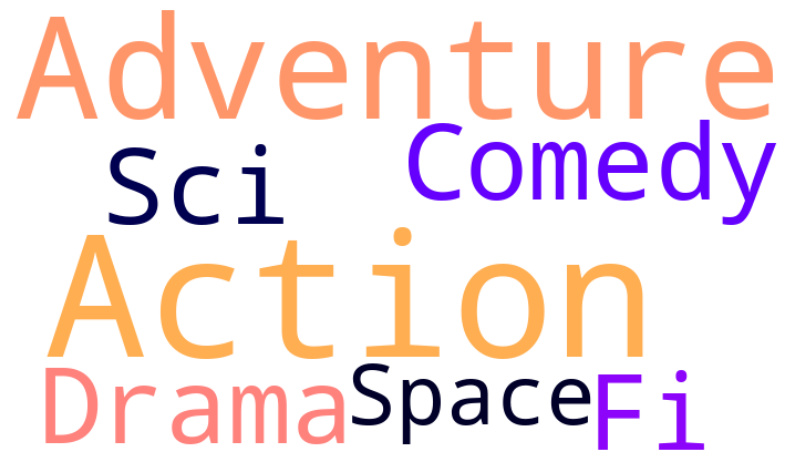

['Action', ' Adventure', ' Comedy', ' Drama', ' Sci-Fi', ' Space']

In [128]:
getFavGenre(x,
           plot=True,
           )


In [129]:
rating_df.head(2)


,user_id,anime_id,rating,user,anime
0,13338,30,0.7,3405,688
1,15967,15583,0.6,4060,1518


In [134]:
def get_user_preferences(user_id, rating_df,df,verbose=0, plot=False):
    animes_watched_by_user = rating_df[rating_df["user_id"] == user_id]
    user_rating_percentile = np.percentile(animes_watched_by_user["rating"], 75)

    animes_watched_by_user = animes_watched_by_user[animes_watched_by_user["rating"] >= user_rating_percentile]

    top_animes_by_user = (
        animes_watched_by_user.sort_values(by="rating", ascending=False)
        .anime_id.values
    )

    anime_df_rows = df[df["anime_id"].isin(top_animes_by_user)]
    anime_df_rows = anime_df_rows[["eng_version", "Genres"]]

    if plot:
        fav_genres = getFavGenre(anime_df_rows, plot=plot)


    if verbose:
        print(f"User {user_id} has watched {len(animes_watched_by_user)} animes with rating greater than {user_rating_percentile}")

    return anime_df_rows



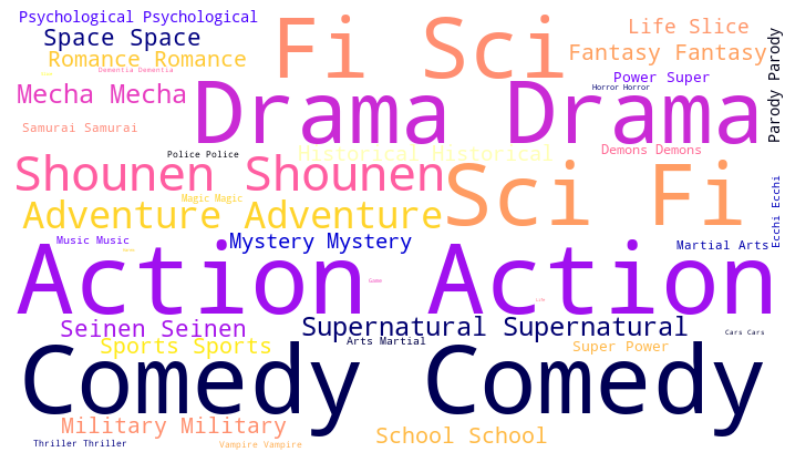

User 11880 has watched 190 animes with rating greater than 0.8


,eng_version,Genres
3971,Fullmetal Alchemist:Brotherhood,"Action, Military, Adventure, Comedy, Drama, Magic, Fantasy, Shounen"
9913,Gintama Season 4,"Action, Comedy, Historical, Parody, Samurai, Sci-Fi, Shounen"
6474,Hunter x Hunter,"Action, Adventure, Fantasy, Shounen, Super Power"
6006,Gintama Season 2,"Action, Sci-Fi, Comedy, Historical, Parody, Samurai, Shounen"
741,Legend of the Galactic Heroes,"Military, Sci-Fi, Space, Drama"
...,...,...
2575,Shootfighter Tekken,"Action, Martial Arts, Shounen"
8064,Samurai Flamenco,"Action, Comedy, Parody, Super Power"
510,Venus Wars,"Action, Sci-Fi, Adventure, Space"
6864,Saint Seiya Omega,"Action, Adventure, Fantasy, Shounen"


In [135]:
get_user_preferences(11880, rating_df, df, verbose=1, plot=True)


#### USER BASED RECOMMENDATION


In [149]:
def get_user_recommendations(similar_users, user_pref, df, synopsys_df,rating_df,n=10):

    recommended_animes = []
    anime_list = []

    for user_id in similar_users.similar_users.values:
        pref_list = get_user_preferences(int(user_id), rating_df, df)

        pref_list = pref_list[~pref_list.eng_version.isin(user_pref.eng_version.values)]

        if not pref_list.empty:
            anime_list.append(pref_list.eng_version.values)

    if anime_list:
        anime_list = pd.DataFrame(anime_list)

        sorted_list = pd.DataFrame(pd.Series(anime_list.values.ravel()).value_counts()).head(n)

        for i, anime_name in enumerate(sorted_list.index):
            n_user_pref = sorted_list[sorted_list.index == anime_name].values[0][0]

            if isinstance(anime_name, str):
                frame = getAnimeFrame(anime_name, df)

                anime_id = frame.anime_id.values[0]
                genre =frame.Genres.values[0]
                synopsis = getSynopsis(int(anime_id))

                recommended_animes.append({
                    "n": n_user_pref,
                    "anime_name": anime_name,
                    "genre": genre,
                    "synopsis": synopsis
                })

    return pd.DataFrame(recommended_animes).head(n)












In [150]:
similar_users = find_similar_users(int(11880), user_weights, user2user_encoded, user2user_decoded, n=10)


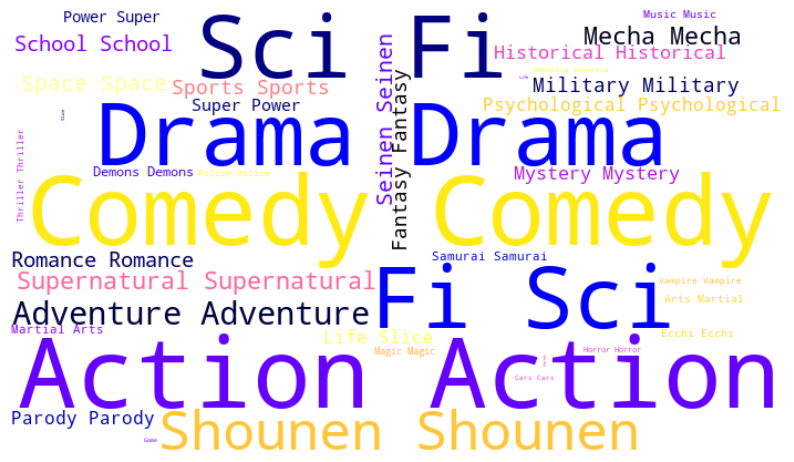

User 11880 has watched 190 animes with rating greater than 0.8


In [151]:
user_pref = get_user_preferences(11880, rating_df, df, verbose=1, plot=True)


In [152]:
get_user_recommendations(similar_users, user_pref, df, synopsys_df, rating_df, n=2)


,n,anime_name,genre,synopsis
0,10,Code Geass:Lelouch of the Rebellion,"Action, Military, Sci-Fi, Super Power, Drama, Mecha, School","In the year 2010, the Holy Empire of Britannia is establishing itself as a dominant military nation, starting with the conquest of Japan. Renamed to Area 11 after its swift defeat, Japan has seen significant resistance against these tyrants in an attempt to regain independence. Lelouch Lamperouge, a Britannian student, unfortunately finds himself caught in a crossfire between the Britannian and the Area 11 rebel armed forces. He is able to escape, however, thanks to the timely appearance of a mysterious girl named C.C., who bestows upon him Geass, the ""Power of Kings."" Realizing the vast potential of his newfound ""power of absolute obedience,"" Lelouch embarks upon a perilous journey as the masked vigilante known as Zero, leading a merciless onslaught against Britannia in order to get revenge once and for all."
1,8,Code Geass:Lelouch of the Rebellion R2,"Action, Military, Sci-Fi, Super Power, Drama, Mecha","One year has passed since the Black Rebellion, a failed uprising against the Holy Britannian Empire led by the masked vigilante Zero, who is now missing. At a loss without their revolutionary leader, Area 11's resistance group—the Black Knights—find themselves too powerless to combat the brutality inflicted upon the Elevens by Britannia, which has increased significantly in order to crush any hope of a future revolt. Lelouch Lamperouge, having lost all memory of his double life, is living peacefully alongside his friends as a high school student at Ashford Academy. His former partner C.C., unable to accept this turn of events, takes it upon herself to remind him of his past purpose, hoping that the mastermind Zero will rise once again to finish what he started, in this thrilling conclusion to the series."


#### HYBRID RECOMMENDER SYSTEM

In [156]:
def hybrid_recommendation(user_id,user_weights=0.5,content_weights=0.5):
    similar_users = find_similar_users(user_id, user_weights, user2user_encoded, user2user_decoded)
    user_pref = get_user_preferences(user_id, rating_df, df)

    user_recommendations = get_user_recommendations(similar_users, user_pref, df, synopsys_df, rating_df, n=10)

    user_recommended_anime_list = user_recommendations["anime_name"].tolist()

    ### Content Based Recommendation    
    content_recommended_animes = []

    for anime in user_recommended_anime_list:
        similar_animes = find_similar_animes(anime, anime_weights, anime2anime_encoded, anime2anime_decoded, df, synopsys_df, n=10)

        if similar_animes is not None and not similar_animes.empty:
            content_recommended_animes.extend(similar_animes["name"].tolist())

        else:
            print(f"No similar animes found for {anime}")


    combined_scores = {}

    for anime in user_recommended_anime_list:
        combined_scores[anime] = combined_scores.get(anime, 0) + user_weights

    for anime in content_recommended_animes:
        combined_scores[anime] = combined_scores.get(anime, 0) + content_weights

    sorted_combined_scores = sorted(combined_scores.items(), key=lambda x: x[1], reverse=True)

    hybrid_recommendations = [anime for anime, score in sorted_combined_scores[:10]]

    return hybrid_recommendations


    
    


In [157]:
hybrid_recommendation(11880)


Error Occurred: 'float' object is not subscriptable


AttributeError: 'NoneType' object has no attribute 'similar_users'